In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.seasonal import seasonal_decompose #library for time series analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

statsmodels.__version__

'0.13.2'

In [2]:
# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

## Load data

In [3]:
# Load data
df = pd.read_csv("dataset_2017_2020.csv")
print('Columns:', df.columns)
print('Num of rows:', df.size)


Columns: Index(['customer_id', 'product_id', 'basket_id', 'loyalty', 'household_type',
       'age_band', 'department', 'brand', 'commodity', 'store',
       'transaction_date', 'price', 'days_since_first'],
      dtype='object')
Num of rows: 1010750


## Data Cleaning

- Check null values
- Check outliers

In [4]:
# Find columns that has null values
df.columns[df.isna().any()].tolist()

[]

Observation: Data is clean, no null values in any columns

In [ ]:
# TODO: check outlier on price or comment on it

### General observations

In [5]:
df.columns

Index(['customer_id', 'product_id', 'basket_id', 'loyalty', 'household_type',
       'age_band', 'department', 'brand', 'commodity', 'store',
       'transaction_date', 'price', 'days_since_first'],
      dtype='object')

In [6]:
# Count number of customer in each loyalty
df.groupby(['loyalty']).size().reset_index(name='counts')


,loyalty,counts
0,First Time Buyer,1134
1,Loyalist,31673
2,Promiscuous,44943


Observation: Low number of First Time Buyer shows that we need more recruitment of new buyer

In [7]:
# Count spending among different customer loyalty
df.groupby('loyalty')['price'].mean()

loyalty
First Time Buyer    3.108051
Loyalist            3.230663
Promiscuous         3.234443
Name: price, dtype: float64

Observation: There is no much different in spending among customer loyalties

In [5]:
## Find profitable departments by total sales
df.groupby('department')['price'].sum().sort_values(ascending=False)

department
Grocery           63537.08
Meat              52443.39
Pharmaceutical    44686.05
Produce           37251.24
Deli              15097.86
Pastry            13759.60
Seafood            8922.92
Nutrition          8810.72
Floral             2588.94
Cosmetics          2536.64
Salad Bar          1580.44
Name: price, dtype: float64

Observation: Grocery department has the highest sales, followed by Meat and Pharmaceutical

In [8]:
# find profitable departments by number of sold items
df.groupby('department').size().sort_values(ascending=False)

department
Grocery           25516
Produce           16184
Pharmaceutical    11646
Meat              10867
Pastry             4648
Deli               3638
Nutrition          2472
Seafood            1494
Salad Bar           484
Cosmetics           456
Floral              345
dtype: int64

Observation: Top 4 departments that customer bought items from are Grocery, Produce, Pharmaceutical and Meat

In [18]:
# Find profitable commodities
popular_items = df.groupby('commodity').size().sort_values(ascending=False)
popular_items_df = pd.DataFrame({'product':popular_items.index, 'count':popular_items.values})
popular_items_df

,product,count
0,Beef,2944
1,Candy,2865
2,Tropical fruit,2148
3,Lunch meat,2078
4,Cheese,2063
...,...,...
242,Continuities,3
243,Glassware/dinnerware,3
244,Overnight photofinishing,3
245,Natural hbc,3


In [21]:
fig = px.treemap(popular_items_df, path=['product'],values='count', width=800, height=400)
fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25))
fig.show()

Observation: Five popular items are Beef, Candy, Tropical fruit, Lunch meat and Cheese

## ARM
Association Rule Mining with Apriori algorithm

In [8]:
products_basket = df[['basket_id','commodity']].groupby(['basket_id'])['commodity'].transform(lambda x: ','.join(x))
products_basket

0        Baked bread/buns/rolls,Vegetables - all others...
1        Baked bread/buns/rolls,Vegetables - all others...
2        Baked bread/buns/rolls,Vegetables - all others...
3        Baked bread/buns/rolls,Vegetables - all others...
4        Baked bread/buns/rolls,Vegetables - all others...
                               ...                        
77745    Analgesics,Frozen meat,Soup,Deli meats,Yogurt,...
77746    Analgesics,Frozen meat,Soup,Deli meats,Yogurt,...
77747    Analgesics,Frozen meat,Soup,Deli meats,Yogurt,...
77748    Analgesics,Frozen meat,Soup,Deli meats,Yogurt,...
77749    Analgesics,Frozen meat,Soup,Deli meats,Yogurt,...
Name: commodity, Length: 77750, dtype: object

In [20]:
data = list(products_basket.apply(lambda x:x.split(",") ))
data

[['Baked bread/buns/rolls',
  'Vegetables - all others',
  'Cold and flu',
  'Paper housewares',
  'Soup',
  'Frozen pizza',
  'Tropical fruit',
  'Heat/serve',
  'Prepared food',
  'Deli meats',
  'Tropical fruit',
  'Apples',
  'Hot dogs',
  'Berries',
  'Lunch meat',
  'Seafood-frozen',
  'Beef',
  'Breakfast sausage/sandwiches',
  'Potatoes',
  'Bread'],
 ['Baked bread/buns/rolls',
  'Vegetables - all others',
  'Cold and flu',
  'Paper housewares',
  'Soup',
  'Frozen pizza',
  'Tropical fruit',
  'Heat/serve',
  'Prepared food',
  'Deli meats',
  'Tropical fruit',
  'Apples',
  'Hot dogs',
  'Berries',
  'Lunch meat',
  'Seafood-frozen',
  'Beef',
  'Breakfast sausage/sandwiches',
  'Potatoes',
  'Bread'],
 ['Baked bread/buns/rolls',
  'Vegetables - all others',
  'Cold and flu',
  'Paper housewares',
  'Soup',
  'Frozen pizza',
  'Tropical fruit',
  'Heat/serve',
  'Prepared food',
  'Deli meats',
  'Tropical fruit',
  'Apples',
  'Hot dogs',
  'Berries',
  'Lunch meat',
  'Seaf

In [22]:
te = TransactionEncoder()
a_data = te.fit(data).transform(data)
items_df = pd.DataFrame(a_data,columns=te.columns_)
items_df = items_df.replace(False,0)
items_df

,Air care,Analgesics,Antacids,Apparel,Apples,Audio/video products,Automotive products,Baby foods,Baby hbc,Bacon,...,Value added fruit,Value added vegetables,Vegetables - all others,Vegetables - shelf stable,Vegetables salad,Vitamins,Warehouse snacks,Water,Water - carbonated/flavoured drinks,Yogurt
0,0,0,0,0,True,0,0,0,0,0,...,0,0,True,0,0,0,0,0,0,0
1,0,0,0,0,True,0,0,0,0,0,...,0,0,True,0,0,0,0,0,0,0
2,0,0,0,0,True,0,0,0,0,0,...,0,0,True,0,0,0,0,0,0,0
3,0,0,0,0,True,0,0,0,0,0,...,0,0,True,0,0,0,0,0,0,0
4,0,0,0,0,True,0,0,0,0,0,...,0,0,True,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77745,0,True,0,0,0,0,0,0,0,0,...,0,0,True,0,0,0,0,True,0,True
77746,0,True,0,0,0,0,0,0,0,0,...,0,0,True,0,0,0,0,True,0,True
77747,0,True,0,0,0,0,0,0,0,0,...,0,0,True,0,0,0,0,True,0,True
77748,0,True,0,0,0,0,0,0,0,0,...,0,0,True,0,0,0,0,True,0,True


In [23]:
frequent_item_sets_df = apriori(items_df, min_support = 0.2, use_colnames = True, verbose = 1)
frequent_item_sets_df

Processing 180 combinations | Sampling itemset size 3


,support,itemsets
0,0.240141,(Apples)
1,0.240514,(Bag snacks)
2,0.321106,(Baked bread/buns/rolls)
3,0.579331,(Beef)
4,0.303871,(Bread)
...,...,...
41,0.214881,"(Lunch meat, Cheese)"
42,0.202842,"(Cheese, Salad)"
43,0.222302,"(Cheese, Tropical fruit)"
44,0.202315,"(Lunch meat, Salad)"


In [24]:
ar_df = association_rules(frequent_item_sets_df, metric = "lift", min_threshold = 1.02)
ar_df.sort_values("confidence",ascending=False)
ar_df

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Beef),(Cheese),0.579331,0.461968,0.274444,0.473725,1.025450,0.006811,1.022341
1,(Cheese),(Beef),0.461968,0.579331,0.274444,0.594075,1.025450,0.006811,1.036323
2,(Beef),(Deli meats),0.579331,0.358148,0.214277,0.369869,1.032726,0.006790,1.018601
3,(Deli meats),(Beef),0.358148,0.579331,0.214277,0.598291,1.032726,0.006790,1.047197
4,(Beef),(Fluid milk products),0.579331,0.333235,0.202572,0.349666,1.049308,0.009519,1.025266
5,(Fluid milk products),(Beef),0.333235,0.579331,0.202572,0.607897,1.049308,0.009519,1.072852
6,(Beef),(Salad),0.579331,0.432386,0.256360,0.442510,1.023416,0.005866,1.018161
7,(Salad),(Beef),0.432386,0.579331,0.256360,0.592897,1.023416,0.005866,1.033322
8,(Lunch meat),(Tropical fruit),0.464617,0.473582,0.232296,0.499972,1.055725,0.012261,1.052778
9,(Tropical fruit),(Lunch meat),0.473582,0.464617,0.232296,0.490508,1.055725,0.012261,1.050817


## Time-series analysis

In [26]:
print(df.transaction_date.unique())

['18/10/2018 0:00' '18/10/2019 0:00' '18/08/2019 0:00' '18/12/2017 0:00'
 '18/09/2017 0:00' '18/12/2018 0:00' '18/11/2018 0:00' '18/09/2018 0:00'
 '18/10/2017 0:00' '18/11/2017 0:00' '18/12/2019 0:00' '18/09/2019 0:00'
 '18/08/2017 0:00' '18/11/2019 0:00' '18/08/2018 0:00' '19/05/2020 0:00'
 '19/02/2017 0:00' '19/01/2019 0:00' '19/01/2020 0:00' '19/02/2019 0:00'
 '19/04/2019 0:00' '19/05/2017 0:00' '19/01/2017 0:00' '19/06/2018 0:00'
 '19/06/2017 0:00' '19/05/2018 0:00' '19/03/2020 0:00' '19/02/2020 0:00'
 '19/04/2020 0:00' '19/03/2019 0:00' '19/04/2017 0:00' '19/03/2017 0:00'
 '19/05/2019 0:00' '19/03/2018 0:00' '19/04/2018 0:00' '19/01/2018 0:00'
 '19/02/2018 0:00' '19/06/2019 0:00' '19/07/2019 0:00' '19/07/2017 0:00'
 '19/07/2018 0:00']


In [27]:

# Transform transaction date
df['t_date'] = pd.to_datetime(df['transaction_date']).dt.date # convert to date, remove time components
df['t_date'] = df.t_date + pd.offsets.MonthBegin(-1) # set to first day of the month
df.head()

,customer_id,product_id,basket_id,loyalty,household_type,age_band,department,brand,commodity,store,transaction_date,price,days_since_first,t_date
0,15803,1131974,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Baked bread/buns/rolls,374,18/10/2018 0:00,0.99,0,2018-10-01
1,15803,1051516,57266,Loyalist,1 adult with kids,19-24,Produce,national,Vegetables - all others,374,18/10/2018 0:00,0.70,0,2018-10-01
2,15803,967254,57266,Loyalist,1 adult with kids,19-24,Pharmaceutical,national,Cold and flu,374,18/10/2018 0:00,1.68,0,2018-10-01
3,15803,1134222,57266,Loyalist,1 adult with kids,19-24,Grocery,private,Paper housewares,374,18/10/2018 0:00,2.59,0,2018-10-01
4,15803,1003421,57266,Loyalist,1 adult with kids,19-24,Grocery,national,Soup,374,18/10/2018 0:00,0.60,0,2018-10-01


##### Aggregate the data
We only need the column date and price for the time series analysis

In [28]:
#Just keep a simple dataframe that will contain the time series.
ts_df = df.groupby(['t_date']).agg(total_revenue=('price', sum)).reset_index()
ts_df.head()

,t_date,total_revenue
0,2017-01-01,5287.93
1,2017-02-01,5738.20
2,2017-03-01,6295.21
3,2017-04-01,5804.32
4,2017-05-01,5461.15


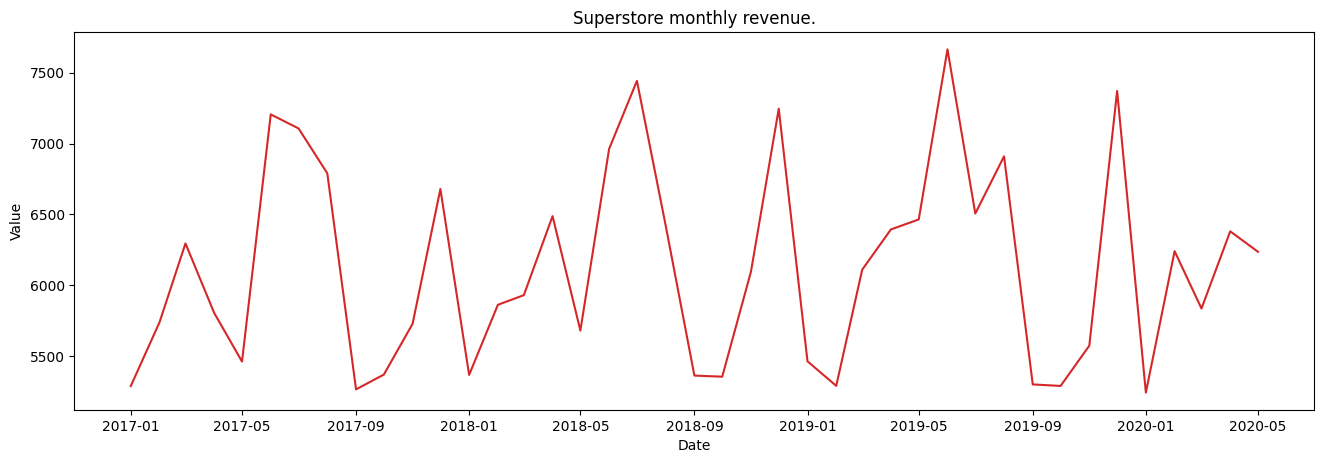

In [38]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(ts_df, x=ts_df['t_date'], y=ts_df.total_revenue, title='Superstore monthly revenue.') 

Observation: There is no trend, but we can see the seasonal factor.

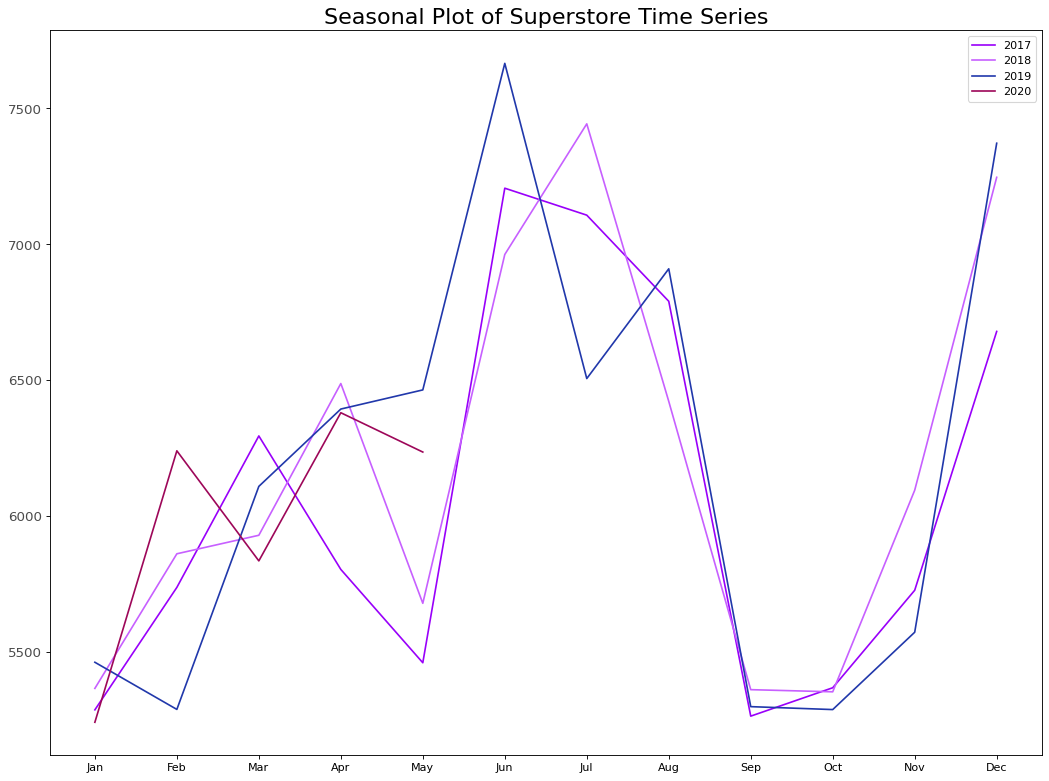

In [85]:
# plot per year to see seasonality

ts_df['year'] = [d.year for d in ts_df.t_date]
ts_df['month'] = [d.strftime('%b') for d in ts_df.t_date]
years = ts_df['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)

for i, y in enumerate(years): 
    plt.plot('month', 'total_revenue', data=ts_df.loc[ts_df.year==y, :], color=mycolors[i], label=y)

# Decoration
plt.legend()
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Superstore Time Series", fontsize=20)
plt.show()

Observation: We can see the pattern that the sales peaks at June, July and December. It drops around September and October

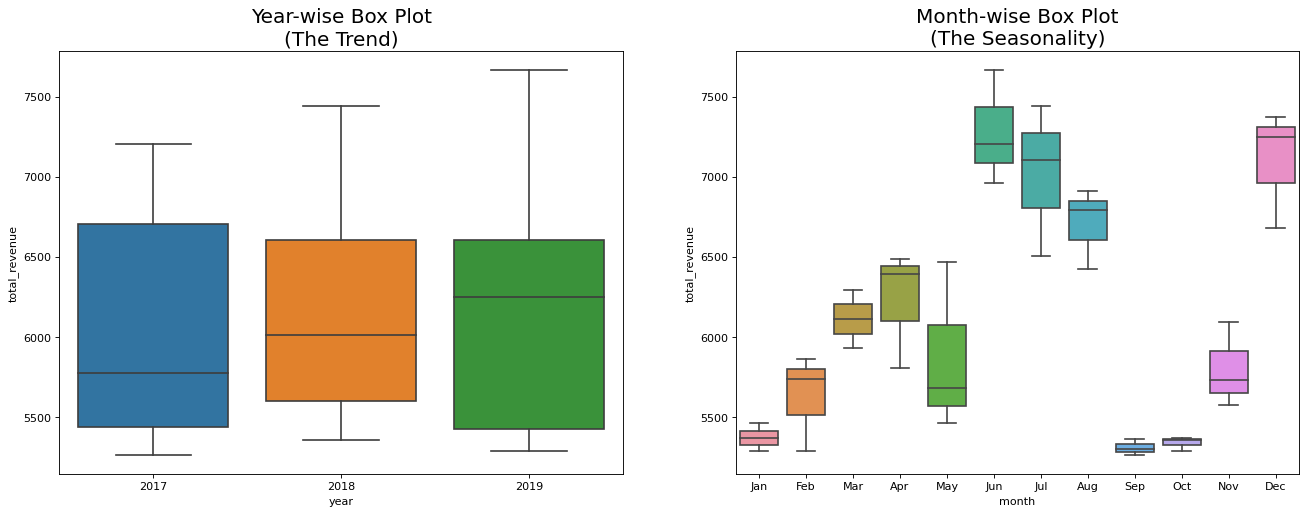

In [90]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='total_revenue', data=ts_df.loc[ts_df.year < 2020, :], ax=axes[0])
sns.boxplot(x='month', y='total_revenue', data=ts_df.loc[ts_df.year < 2020, :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

##### Decompose timeseries into components

In [ ]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(x=ts_df, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(x=ts_df, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

##### Build a training dataset
Use data beore 01/01/2020 as a training data

In [94]:
training = ts_df.loc[ts_df.t_date < '2020-01-01'].set_index('t_date')
training.shape

(36, 3)

In [100]:
training = training.drop(['year', 'month'], axis=1)
training.head()

,total_revenue
t_date,
2017-01-01,5287.93
2017-02-01,5738.20
2017-03-01,6295.21
2017-04-01,5804.32
2017-05-01,5461.15


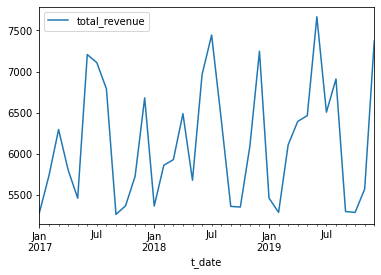

In [101]:
training.plot();


##### Performed the following time series analysis
- Observed (actual data)
- Trend (direction)
- Seasonal (repeated patterns)
- Residuals (noise)

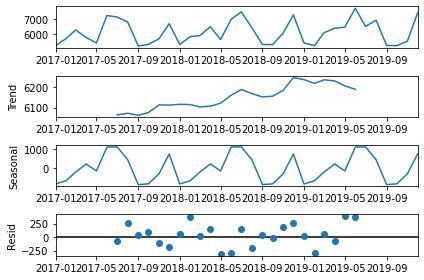

In [102]:
ts_components = seasonal_decompose(training)
ts_components.plot();

##### Check for stationarity using mean and variance
Compare mean and variance of the first half and the second half of our data.

In [103]:
#Split the training data in half
split = round(len(training) / 2) # Find mid-point
x1 = training[0:split] # Extract first half
x2 = training[split:]  # Extract second half

# Calculate means
mean1= x1.mean()
mean2= x2.mean()
print("Mean 1 & 2 = ", round(mean1[0]), round(mean2[0]))

# Calculate variances
var1=x1.var()
var2=x2.var()
print("Variance 1 & 2 = ",round(var1[0]), round(var2[0]))

Mean 1 & 2 =  6057 6237
Variance 1 & 2 =  435630 690131


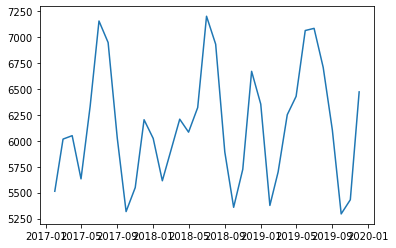

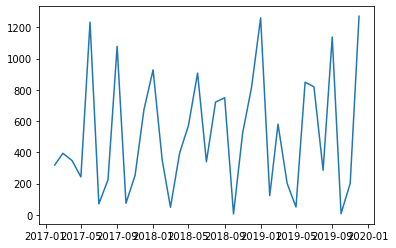

In [104]:
plt.plot(training.rolling(window=2).mean())
plt.show()
plt.plot(training.rolling(window=2).std())
plt.show()

Observation: Means are around the same value, but variances seem to be in different ranges. 

##### Use Augmented Dickey-Fuller (ADF) and p-value to further test 
- H0: Data has unit root (not stationary)
- H1: No unit root (stationary)

In [105]:
# Run test:
test_adf = adfuller(training)

#Output the results:
print('ADF test = ', test_adf[0])
print('p-value = ', test_adf[1])

ADF test =  -3.91822361539971
p-value =  0.001904750392803885


the ADF value is negative, it rejects H0,  and p-value < 0.05, we can reject the null hyphotesis and assume that our time series is stationary. Now we are ready to apply a forecasting method.


##### Check autocorrelation to choose a p parameter for ARIMA model
- Create an autocorrelation plot to find the correct lag. Lag is the number of previous observations)
- When the correlation value is closer to 0, it is reveals there is randomness in our data (don't use this)
- A correlation of 1 (or -1) means we can use the delayed series to predict the current series entirely 

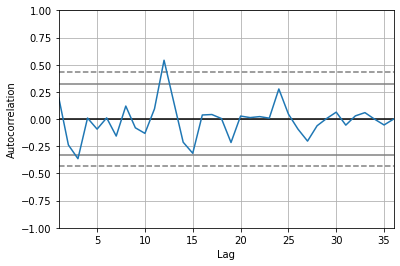

In [106]:
autocorrelation_plot(training);

Observation In our data
- The data point **12** months prior shows high correlation, however, it's a long lag
- The point **3** months prior (The **negative correlation** indicates that three months prior to a data point tends to be a very different value to the current value). 
- Use *p = 3* as a compromise between a shorter lag and the level of autocorrelation


##### Define a test dataset
One guide is to use 70% of the dataset for training and 30% for testing; however, **in time series, a better result is had by using full periods** in the training data. So we use three full years of data as the training (2017 – 2019), and the first five months of 2020 for prediction/test

In [107]:
# Extract all data after and including Jan 2020.
test = ts_df.loc[ts_df.t_date >= '2020-01-01'].set_index('t_date')

# Have a look at our test datset:
print(test)

            total_revenue month  year
t_date                               
2020-01-01        5242.21   Jan  2020
2020-02-01        6240.52   Feb  2020
2020-03-01        5835.69   Mar  2020
2020-04-01        6380.56   Apr  2020
2020-05-01        6235.96   May  2020


##### Prepare data for ARIMA model
Create data series to feed into ARIMA model. history for the training data and future for the test data.

In [108]:
# Transform our data in a series, where the index is the time series
whole = ts_df.set_index('t_date').squeeze().copy()
# history is going to countain our training data as a time series
history = training.take(range(36))
# future contains the test data, also as a time series
future = test.squeeze().copy()

##### Run ARIMA model to forecast over our test data.
We are now ready to build our ARIMA models, using the following parameters:
- p=3 (based on the autocorrelation plot), 
- d=0, i.e. no differencing required because in we concluded data is stationary, 
- q=0, meaning we do not use a moving average in this model.

We now use a `for` loop. In this loop, we use the trainign data to run an ARIMA model to predict the next month, and output the results. We then step forward and add another month's data from the test data into the training data so we can then predict one more month ahead, repeating the process. This means we predict month by month until we get to the end of our test dataset. The results show our predicted value for each of the test data months, followed by the actual data for that month to allow us to compare how accurate the data is.

In [113]:
for t in range(len(future)):
    
    model = ARIMA(history, order=(3,0,0), freq='MS')
    
    model_fit = model.fit()
    
    # use the forecast method to compute the predictions, in this case we just want the prediction for the next month
    # change steps value to increase the prediction range
    # Output will return three values:
    # 0 - the list of predicted values with size steps 
    # 1 - the calculated standard error of the prediction
    # 2 - the confidence interval of the prediction given the standard error
    output = model_fit.forecast()
    print(output)

    # # # yhat is the value predicted by the model, in this case just one month
    # yhat = output[0].round(2) 
    # # stderr is the standard error of the prediction:
    # stderr = output[1].round(2) 
    
    # # #confint is the confidnece interval given the standard error:
    # confint = output[2].round(2) 
    
    # # # obs is the actual value observed for the predicted month, so we will compare predicted value v observed (real) value
    # month = future.index[t]
    # obs = future[t].round(2)
    
    # # # print the forecast revenue vs the observed revenue (since Jan 2020)
    # print(month)
    # print('prediction:', yhat, ', expected:', obs, ', stderr:', stderr, ', conf. int:', confint)
    
    # # # note that with each run, ARIMA will be run with the last observed value, so we just extend from the original time series
    # history = whole.take(range(36 + t+1))
    

C:\Users\welli\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\welli\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2020-01-01    6815.502058
Freq: MS, dtype: float64
2020-01-01    6815.502058
Freq: MS, dtype: float64


C:\Users\welli\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\welli\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


2020-01-01    6815.502058
Freq: MS, dtype: float64
2020-01-01    6815.502058
Freq: MS, dtype: float64
2020-01-01    6815.502058
Freq: MS, dtype: float64


C:\Users\welli\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### Step 15: Interpret results of ARIMA models 
Note that with each run, ARIMA will be run with the last observed value, so we just extend from the original time series to include another test data point, and re-run the model to forecast the next month.

Also note how, with each iteration, the gap between predicted and observed values is narrowing, as the model begins "learning" from newly observed data.

### Step 16: Forecast new data into the future.
Until this point we have been “forecasting” months for which we knew the actual figure, to allow us to compare and assess our model. Now we move to true prediction, forecasting 12 ‘steps’ (or months) forward. The prediction is extended (through ‘steps’) to investigate data from June 2020 to May 2021, which we have no actual data for.

In [41]:
# Predict the revenue of the next 12 months (from June 2020 to May 2021)
# note we need running ARMA again so it captures the last observed value

model = ARIMA(history, order=(3,0,0), freq='MS')
model_fit = model.fit(disp=0)
output = model_fit.forecast(steps=12)


### Step 17: Interpret the results of our forecast

You can see that revenue is predicted to remain steady with little trends:

In [42]:
output[0].round(2) # The first set of output shows the predicted values for the following twelve months.

array([6194.3 , 6049.12, 6086.92, 6125.1 , 6166.17, 6152.33, 6133.31,
       6121.49, 6127.61, 6135.68, 6138.97, 6136.16])

While we can train and make predictions with our model, the autocorrelation plot showed us that there is a random effect in our data, so the predictions done with our method will be less accurate. Just have a look at the confidence interval of the predicted values:

In [44]:
# Confidence intervals:
output[2].round(2)

array([[4919.45, 7469.15],
       [4769.79, 7328.44],
       [4793.81, 7380.03],
       [4766.66, 7483.55],
       [4807.2 , 7525.15],
       [4788.24, 7516.41],
       [4761.95, 7504.68],
       [4750.12, 7492.87],
       [4755.06, 7500.17],
       [4762.29, 7509.07],
       [4765.57, 7512.37],
       [4762.53, 7509.78]])

It covers almost $3k difference (confidence intervals)! But with the more data we observe, we might be improving our prediction as it goes!